# 0. Prerequisites

In [ ]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import PIL
import os
import random
from tensorflow import keras

# Superglobals
GLOBAL_SEED = 1
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224

# Seeding
keras.utils.set_random_seed(GLOBAL_SEED)

# Library Setup
sns.set_style('whitegrid')

In [ ]:
# Dataset Download
source = "https://raw.githubusercontent.com/subtle64/Datasets/main/Others/Data%20A.zip"
tf.keras.utils.get_file(origin = source, extract = True)
path = pathlib.Path('/root/.keras/datasets/Data')

In [ ]:
os.listdir(path)

['test', 'train', 'valid']

In [ ]:
# Check the data we have, very small testing set.
dir_images = list(path.rglob('*.*'))
dir_train = list(path.rglob('train/*/*.*'))
dir_val = list(path.rglob('valid/*/*.*'))
dir_test = list(path.rglob('test/*/*.*'))
print(f"Total images: {len(dir_images)}")
print(f"Total training data: {len(dir_train)}")
print(f"Total validation data: {len(dir_val)}")
print(f"Total testing data: {len(dir_test)}") # But why tho? Only 6?

Total images: 3006
Total training data: 2800
Total validation data: 200
Total testing data: 6


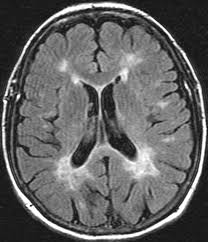

In [ ]:
# Take a random image from the dataset, most likely medical imaging
PIL.Image.open(dir_images[random.randint(0, len(dir_images) - 1)])

# Question 2:

#### **a.** Perform data augmentation if necessary and resize the image resolution to 64 x 64.

I have no idea why we need to resize to 64 x 64 if the model uses 224 x 224 as input, since it won't be necessary, I straightaway resized it to 224 x 224 instead.


Example Code if we wanted to resize to 64 x 64:
```
ds_train_64 = augmentation.flow_from_directory(
  str(path) + '/train',
  target_size = (64, 64),
  batch_size = BATCH_SIZE,
  seed = GLOBAL_SEED,
)

ds_val_64 = keras.utils.image_dataset_from_directory(
  str(path) + '/valid',
  image_size=(64, 64),
  batch_size=BATCH_SIZE,
  label_mode = 'categorical'
)

ds_test_64 = keras.utils.image_dataset_from_directory(
  str(path) + '/test',
  image_size=(64, 64),
  label_mode = 'categorical',
)
```



In [ ]:
from keras.preprocessing.image import ImageDataGenerator
augmentation = ImageDataGenerator(
    rotation_range = 15, # Since even if you rotate brain images, it's still a brain
    horizontal_flip = True, # Flipping won't change info
    vertical_flip = True, # Flipping won't change info
    shear_range = 0.3, # Shear will cause the model to learn if aspect ratio is not conserved
)

In [ ]:
ds_train = augmentation.flow_from_directory(
  str(path) + '/train',
  target_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE,
  seed = GLOBAL_SEED,
)

ds_val = keras.utils.image_dataset_from_directory(
  str(path) + '/valid',
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE,
  label_mode = 'categorical'
)

ds_test = keras.utils.image_dataset_from_directory(
  str(path) + '/test',
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  label_mode = 'categorical',
)

Found 2800 images belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 6 files belonging to 2 classes.


In [ ]:
# Optimize
ds_val = ds_val.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
ds_test = ds_test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

#### **b.** Make the baseline architecture according to Figure 1 below: (Note: Activation function for each hidden layer using ReLU, last layer using softmax). Display validation loss and training loss graphs. Explain whether the model is overfit, underfit or just right model?

In [ ]:
from tensorflow import keras
from keras import layers

input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

# MODEL - 1 DEFINITION
inputs = keras.Input(input_shape)

conv2D_1 = layers.Conv2D(96, 11, strides = 4, activation = "relu")(inputs)
maxPool_1 = layers.MaxPool2D(3, strides = 2)(conv2D_1)

conv2D_2 = layers.Conv2D(256, 5, activation = "relu")(maxPool_1)
pad_2 = keras.layers.ZeroPadding2D(2)(conv2D_2)
maxPool_2 = layers.MaxPool2D(3, strides = 2)(pad_2)

conv2D_3 = layers.Conv2D(384, 3, activation = "relu")(maxPool_2)
pad_3 = keras.layers.ZeroPadding2D(1)(conv2D_3)

conv2D_4 = layers.Conv2D(384, 3, activation = "relu")(pad_3)
pad_4 = keras.layers.ZeroPadding2D(1)(conv2D_4)

conv2D_5 = layers.Conv2D(256, 3, activation = "relu")(pad_4)
pad_5 = keras.layers.ZeroPadding2D(1)(conv2D_5)
maxPool_5 = layers.MaxPool2D(3, strides = 2)(pad_5)

flatten = layers.Flatten()(maxPool_5)
dense_1 = layers.Dense(4096, activation = "relu")(flatten)
dense_2 = layers.Dense(4096, activation = "relu")(dense_1)
outputs = layers.Dense(2, activation = "softmax")(dense_2)
# END MODEL - 1 DEFINITION

cnn_1 = keras.Model(inputs, outputs)

In [ ]:
cnn_1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
cnn_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 256)       614656    
                                                                 
 zero_padding2d (ZeroPaddin  (None, 26, 26, 256)       0         
 g2D)                                                            
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 256)       0     

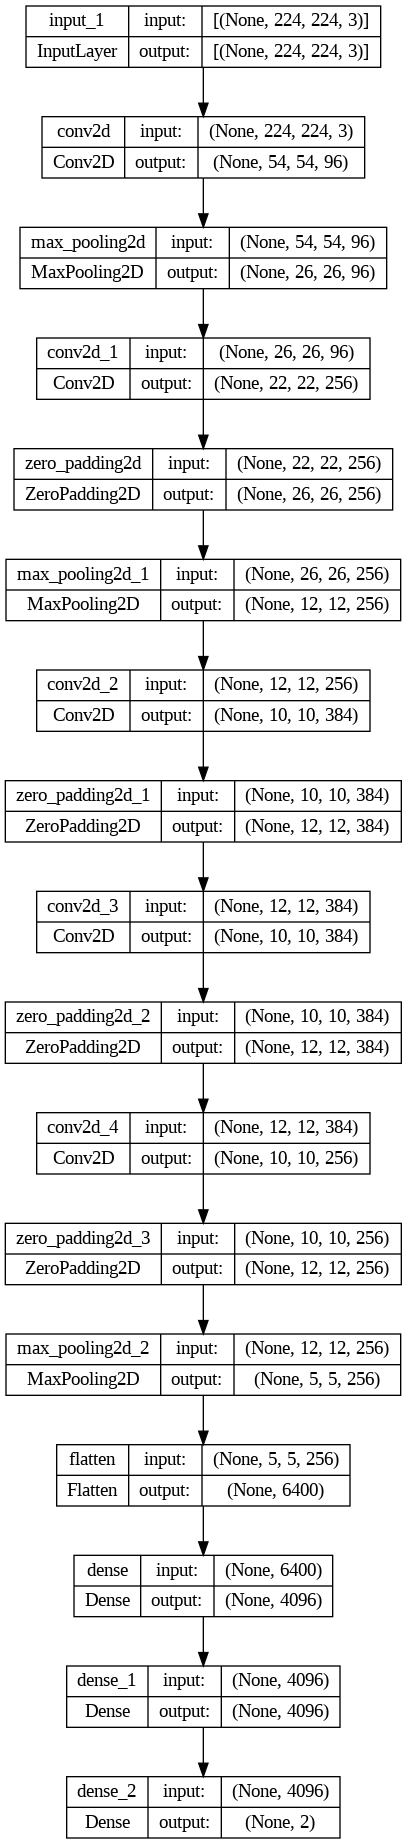

In [ ]:
from keras.utils import plot_model
plot_model(cnn_1, show_shapes = True)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 25,
        verbose = 1,
        restore_best_weights = True
    )
]

In [ ]:
cnn1_results = cnn_1.fit(
    ds_train,
    validation_data = ds_val,
    epochs = 100,
    callbacks = callbacks
)

Epoch 1/100
88/88 [==============================] - 48s 406ms/step - loss: 97.6226 - categorical_accuracy: 0.6861 - val_loss: 0.5730 - val_categorical_accuracy: 0.6850
Epoch 2/100
88/88 [==============================] - 49s 553ms/step - loss: 0.4990 - categorical_accuracy: 0.7668 - val_loss: 0.4683 - val_categorical_accuracy: 0.7850
Epoch 3/100
88/88 [==============================] - 33s 377ms/step - loss: 0.4759 - categorical_accuracy: 0.7786 - val_loss: 0.4997 - val_categorical_accuracy: 0.7450
Epoch 4/100
88/88 [==============================] - 33s 370ms/step - loss: 0.4245 - categorical_accuracy: 0.8196 - val_loss: 0.4644 - val_categorical_accuracy: 0.7850
Epoch 5/100
88/88 [==============================] - 32s 362ms/step - loss: 0.4107 - categorical_accuracy: 0.8250 - val_loss: 0.5257 - val_categorical_accuracy: 0.7750
Epoch 6/100
88/88 [==============================] - 31s 353ms/step - loss: 0.4228 - categorical_accuracy: 0.8111 - val_loss: 0.5210 - val_categorical_accuracy

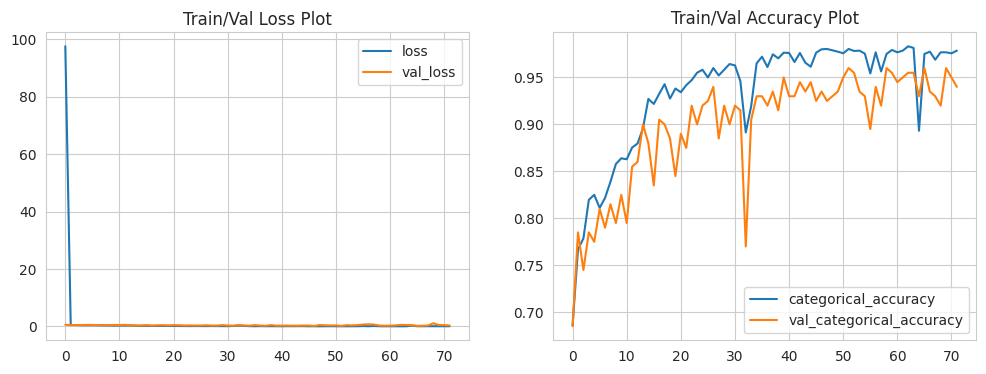

In [ ]:
def plot_training_graphs(results):
  fig, axes = plt.subplots(1, 2, figsize = (12, 4))
  graph = pd.DataFrame(results.history)
  graph.loc[:, ['loss', 'val_loss']].plot(ax = axes[0], title = "Train/Val Loss Plot")
  graph.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot(ax = axes[1], title = "Train/Val Accuracy Plot")

plot_training_graphs(cnn1_results)

In [ ]:
from sklearn.metrics import classification_report
def evaluate_model(model, ds):
  y_pred = model.predict(ds)
  y_true = [np.argmax(y, axis = 1) for x, y in ds][0]
  print("Probabilities:\n", y_pred)
  print(classification_report(y_true, np.argmax(y_pred, axis = 1)))

evaluate_model(cnn_1, ds_test)

1/1 [==============================] - 0s 15ms/step
Probabilities:
 [[8.8374701e-04 9.9911624e-01]
 [9.9151772e-01 8.4822755e-03]
 [9.9997234e-01 2.7685857e-05]
 [2.1289831e-03 9.9787104e-01]
 [9.9999905e-01 9.0429256e-07]
 [1.5603788e-01 8.4396213e-01]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



There are a few issues here:
1. The test set is so small, even with the baseline it achieves perfect accuracy.
2. The model overfits a bit to the training set. Why? Even if the graphs are not quite clear, it is obvious since the training loss has reach all the way down to 0.0X range while validation loss is stuck at 0.1490 at best.  

#### **c.** Modify the architecture in number 2b by using dropout, batch normalization, and other methods. Give reasons why your architecture modification is better than the benchmark.

In [ ]:
# MODEL - 2 DEFINITION
inputs = keras.Input(input_shape)

conv2D_1 = layers.Conv2D(96, 11, strides = 4, activation = "relu")(inputs)
maxPool_1 = layers.MaxPool2D(3, strides = 2)(conv2D_1)
dropout_1 = layers.Dropout(0.2)(maxPool_1)
norm_1 = layers.BatchNormalization()(dropout_1)

pad_2 = keras.layers.ZeroPadding2D(2)(norm_1)
conv2D_2 = layers.Conv2D(256, 5, activation = "relu")(pad_2)
maxPool_2 = layers.MaxPool2D(3, strides = 2)(conv2D_2)
dropout_2 = layers.Dropout(0.2)(maxPool_2)
norm_2 = layers.BatchNormalization()(dropout_2)

pad_3 = keras.layers.ZeroPadding2D(1)(norm_2)
conv2D_3 = layers.Conv2D(384, 3, activation = "relu")(pad_3)
dropout_3 = layers.Dropout(0.2)(conv2D_3)
norm_3 = layers.BatchNormalization()(conv2D_3)

pad_4 = keras.layers.ZeroPadding2D(1)(norm_3)
conv2D_4 = layers.Conv2D(384, 3, activation = "relu")(pad_4)
dropout_4 = layers.Dropout(0.2)(conv2D_4)
norm_4 = layers.BatchNormalization()(dropout_4)

pad_5 = keras.layers.ZeroPadding2D(1)(norm_4)
conv2D_5 = layers.Conv2D(256, 3, activation = "relu")(pad_5)
maxPool_5 = layers.GlobalMaxPooling2D()(conv2D_5)
dropout_5 = layers.Dropout(0.2)(maxPool_5)
norm_5 = layers.BatchNormalization()(dropout_5)

flatten = layers.Flatten()(norm_5)
dense_1 = layers.Dense(4096, activation = "relu")(flatten)
dropout_6 = layers.Dropout(0.2)(dense_1)

dense_2 = layers.Dense(4096, activation = "relu")(dense_1)
dropout_7 = layers.Dropout(0.2)(dense_2)

outputs = layers.Dense(2, activation = "softmax")(dropout_7)
# END MODEL - 2 DEFINITION

cnn_2 = keras.Model(inputs, outputs)

In [ ]:
cnn_2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
cnn_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 26, 26, 96)        0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 26, 26, 96)        0         
                                                                 
 batch_normalization_10 (Ba  (None, 26, 26, 96)        384       
 tchNormalization)                                               
                                                                 
 zero_padding2d_12 (ZeroPad  (None, 30, 30, 96)        0   

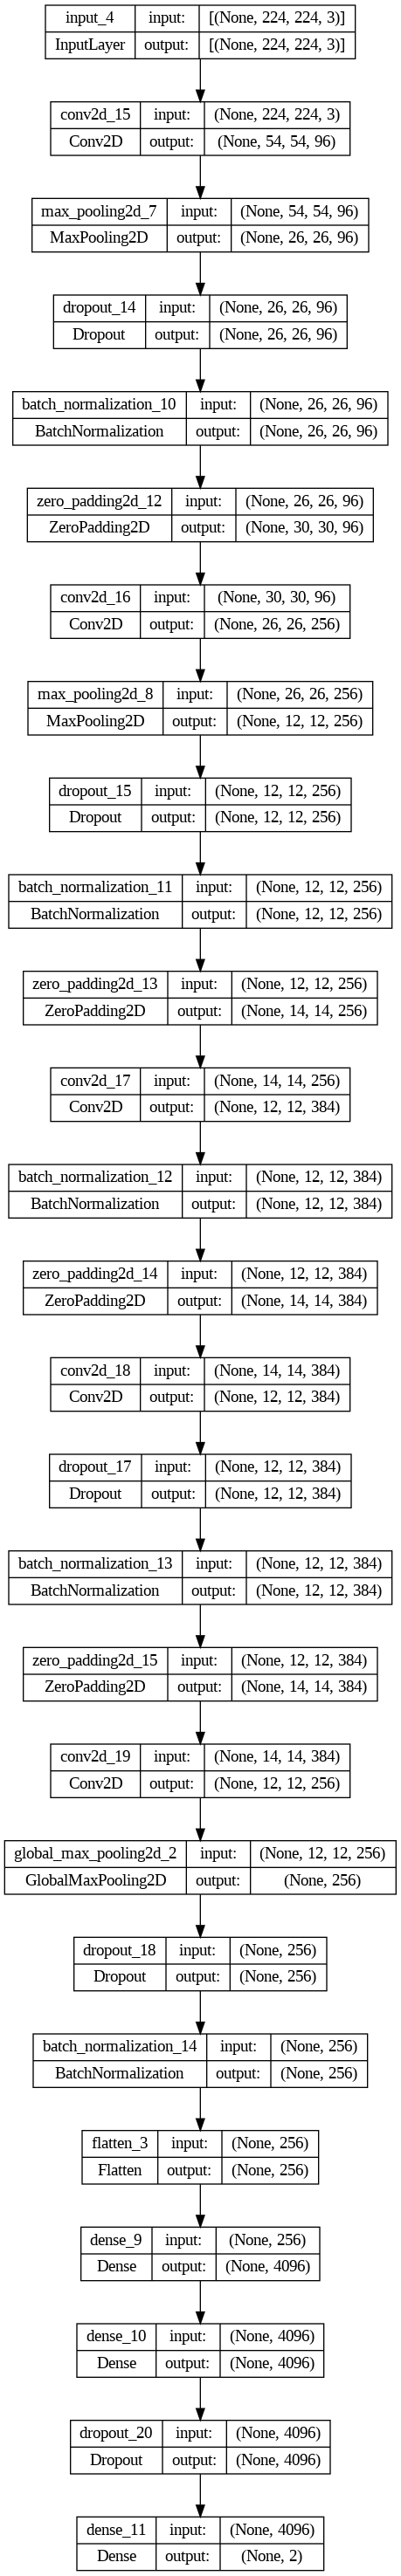

In [ ]:
plot_model(cnn_2, show_shapes = True)

In [ ]:
cnn2_results = cnn_2.fit(
    ds_train,
    validation_data = ds_val,
    epochs = 100,
    callbacks = callbacks
)

Epoch 1/100
88/88 [==============================] - 38s 387ms/step - loss: 0.6609 - categorical_accuracy: 0.7686 - val_loss: 5.5988 - val_categorical_accuracy: 0.6300
Epoch 2/100
88/88 [==============================] - 34s 387ms/step - loss: 0.2868 - categorical_accuracy: 0.8729 - val_loss: 2.7165 - val_categorical_accuracy: 0.6000
Epoch 3/100
88/88 [==============================] - 34s 391ms/step - loss: 0.2519 - categorical_accuracy: 0.8929 - val_loss: 1.7020 - val_categorical_accuracy: 0.6600
Epoch 4/100
88/88 [==============================] - 35s 403ms/step - loss: 0.2268 - categorical_accuracy: 0.9154 - val_loss: 0.3408 - val_categorical_accuracy: 0.8850
Epoch 5/100
88/88 [==============================] - 35s 392ms/step - loss: 0.2051 - categorical_accuracy: 0.9221 - val_loss: 0.8485 - val_categorical_accuracy: 0.6550
Epoch 6/100
88/88 [==============================] - 35s 395ms/step - loss: 0.1771 - categorical_accuracy: 0.9304 - val_loss: 0.6695 - val_categorical_accuracy:

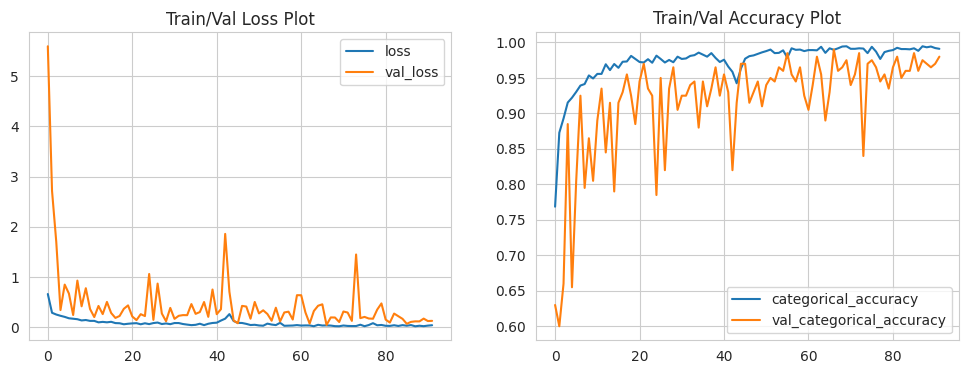

In [ ]:
plot_training_graphs(cnn2_results)

In [ ]:
evaluate_model(cnn_2, ds_test)

1/1 [==============================] - 0s 26ms/step
Probabilities:
 [[0.0000000e+00 1.0000000e+00]
 [9.9974698e-01 2.5300894e-04]
 [1.0000000e+00 1.0156501e-09]
 [2.6142824e-10 1.0000000e+00]
 [9.9994385e-01 5.6156416e-05]
 [2.6995222e-33 1.0000000e+00]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



I added a few changes in the architecture. Firstly, I added dropout and batch normalization layers in the architecture, and also changed the last MaxPooling to GlobalMaxPooling instead. It performs better with my experience on the Hymenoptera dataset.

This model is better for two reasons:
1. We fixed the overfitting isue, the validation loss at best now reaches 0.0436, whereas the training loss was 0.0354.
2. From the probabilities printed in the classification report, we can see that the magnitude of difference between the two classes is greater, meaning the model is way more confident than the first (with one exception on the fifth test case).
3. However, I do note that the model is still "jumpy" with the validation loss. With higher epochs and slower learning rate, but I don't have the time to train that long.

#### **d.** Evaluate the performance of architecture number 2c and explain your results. Use the given testing set to predict the ground truth value with the predicted result.

In [ ]:
evaluate_model(cnn_1, ds_test)

1/1 [==============================] - 0s 25ms/step
Probabilities:
 [[8.8374701e-04 9.9911624e-01]
 [9.9151772e-01 8.4822755e-03]
 [9.9997234e-01 2.7685857e-05]
 [2.1289831e-03 9.9787104e-01]
 [9.9999905e-01 9.0429256e-07]
 [1.5603788e-01 8.4396213e-01]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [ ]:
evaluate_model(cnn_2, ds_test)

1/1 [==============================] - 0s 15ms/step
Probabilities:
 [[0.0000000e+00 1.0000000e+00]
 [9.9974698e-01 2.5300894e-04]
 [1.0000000e+00 1.0156501e-09]
 [2.6142824e-10 1.0000000e+00]
 [9.9994385e-01 5.6156416e-05]
 [2.6995222e-33 1.0000000e+00]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



Both models already reach 100% accuracy since, well, the test size is only 6! However, the newer model is able to predict with higher degree of certainty than the baseline, since the magnitude difference is greater for the probabilities.

#### **f.** Create a video to explain each code made to solve the above problems, provide an explanation of the architecture and results, and share your opinion on the evaluation result.


Link Video: https://youtu.be/o8C6SBK_QKs (Menit ke 12:52 - 21:37)